- Application 2: QAOA
  - Max Cut
  - framework (analog to neural network)
  - circuit 
  - loss function
  - optimization: gradient descent

### Variational quantum algorithms (Quantum neural network)

#### Workflow

1. Define the problem and the cost function
2. Choose circuit ansatz
3. Get value of the cost (and gradient, etc)
4. Update parameters

#### Max Cut

Given a graph $G = (V, E)$, find a partition of nodes that goes through the maximum number of edges. Below is a random 3-regular graph with 6 nodes.

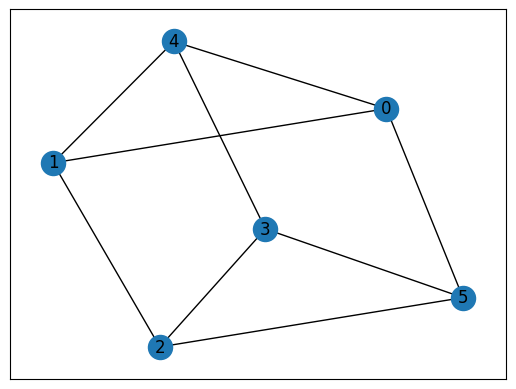

In [1]:
import numpy as np
import networkx as nx

n, d = 6, 3
G = nx.random_regular_graph(d, n, seed = 0)
w = nx.to_numpy_array(G) # adjacency matrix

labels = {i: i for i in range(n)}
pos = nx.spring_layout(G, seed=0)
nx.draw_networkx(G, pos, with_labels=True, labels=labels);

Use $x \in \{0,1\}^n$ to denote a "cut" or a partition, where $x_i = 0$ means the $i$-th node is in the first partition and $x_i = 1$ means that it is in the second one.

The objective function associated with the cut $x$ is defined as 
$$
C(x) = \sum_{(i, j) \in E} x_i \oplus x_j = \frac{1}{2} \sum_{(i, j) \in E} \left( 1 - (-1)^{x_i + x_j} \right)
$$



In [2]:
def cut_value(x: np.ndarray, G: nx.Graph) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        G: Graph.
    Returns:
        Value of the cut.
    """
    obj = 0
    for i, j in G.edges():
        # obj += (x[i] + x[j] - 2*x[i]*x[j])
        obj += 1/2 * (1 - (-1)**(x[i] + x[j]))

    return obj

def binary_repr(n: int, L: int) -> list[int]:
    """
    Wrapper for np.binary_repr that returns a list of ints instead of a string.
    """
    return [int(digit) for digit in np.binary_repr(n, L)]  

Exercise: Validate the cut that separates nodes 0, 4 with the others.

In [5]:
cut_value([1, 0, 0, 0, 1, 0], G)

4.0

Brute-force method: try all possible $x$ and output the one with maximum objective value

In [6]:
max_cut_value = 0

for i in range(2**n):
    x = binary_repr(i, n)
    if cut_value(x, G) > max_cut_value:
        max_cut_value = cut_value(x, G)
        best_cut = x

print(f'Objective value computed by the brute-force method is {max_cut_value} with the cut {best_cut}')

Objective value computed by the brute-force method is 7.0 with the cut [0, 0, 1, 0, 1, 1]


Mapped to an Ising Hamiltonian: $(-1)^{x_i} \to Z_i$

The observable for the cut value is given by
$$
H_C = \frac{1}{2} \sum_{(i, j) \in E} (I - Z_i Z_j)
$$

In [14]:
from qiskit.quantum_info import Pauli, SparsePauliOp

Exercise: write a function `max_cut_hamiltonian` that takes a graph `G` as input and returns the Hamiltonian.

In [34]:
def max_cut_hamiltonian(G: nx.Graph) -> SparsePauliOp:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    ham = m/2 * SparsePauliOp("I"*n)
    for i, j in G.edges():
        z = np.zeros(n)
        z[i] = 1
        z[j] = 1
        ham += - 1/2 * SparsePauliOp(Pauli((z, np.zeros(n))))

    return ham

In [48]:
ham = max_cut_hamiltonian(G)

Exercise: Validate the function `max_cut_hamiltonian` by checking the maximum eigenvalue of `ham`

Hint: Check the documentation of [`SparsePauliOp`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp). Use `to_matrix()` to get an numpy array.

In [49]:
from numpy.linalg import eigvals

ham_matrix = ham.to_matrix()
print(f'Maximum eigenvalue of the Hamiltonian is {max(eigvals(ham_matrix))}')

Maximum eigenvalue of the Hamiltonian is (7+0j)


QAOA

We first define a helper function that returns the bit string with highest occurring probability when measuring a state vector.

In [57]:
from qiskit.quantum_info import Statevector
from qiskit.result import QuasiDistribution

def sample_most_likely(state_vector: Statevector | QuasiDistribution) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = binary_repr(k, n)
    # x.reverse()
    return np.asarray(x)

In [58]:
print(Statevector.from_label('110'))
print(sample_most_likely(Statevector.from_label('110')))

Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j,
             0.+0.j],
            dims=(2, 2, 2))
[1 1 0]


Below is to use the functions already written by qiskit

In [60]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals

sampler = Sampler()

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(-ham)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {cut_value(x, G)}')

C:\Users\buyet\AppData\Local\Temp\ipykernel_8848\4241725682.py:8: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 10598


[0 0 1 0 1 1]
Objective value computed by QAOA is 7.0


Different ansatz

In [64]:
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(ham.num_qubits, "ry", "cz", reps=2, entanglement="linear")
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer)

result = sampling_vqe.compute_minimum_eigenvalue(-ham)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by VQE is {cut_value(x, G)}")

C:\Users\buyet\AppData\Local\Temp\ipykernel_8848\2600707265.py:5: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 10598


[1 0 1 0]


IndexError: index 4 is out of bounds for axis 0 with size 4

In [36]:
import qiskit.tools.jupyter
%qiskit_version_table